In [1]:
import pandas as pd
import numpy as np

## 4.1.3 Thought experiment

In [5]:
topic = {}
tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), np.random.rand(6))))
topic['pet'] = (.3 * tfidf['cat'] + .3 * tfidf['dog'] + 0 * tfidf['apple']
                + 0 * tfidf['lion'] - .2 * tfidf['NYC'] + .2 * tfidf['love'])
topic['animal'] = (.1 * tfidf['cat'] + .1 * tfidf['dog'] - .1 * tfidf['apple']
                   + .5 * tfidf['lion'] + .1 * tfidf['NYC'] - .1 * tfidf['love'])
topic['city'] = (0 * tfidf['cat'] - .1 * tfidf['dog'] + .2 * tfidf['apple']
                 - .1 * tfidf['lion'] + .5 * tfidf['NYC'] + .1 * tfidf['love'])


In [6]:
tfidf

{'cat': 0.9871763267567475,
 'dog': 0.7465351407870877,
 'apple': 0.4856632597847713,
 'lion': 0.40480884892372215,
 'NYC': 0.7852863707256033,
 'love': 0.994076484077344}

In [7]:
topic

{'pet': 0.5618714629334987,
 'animal': 0.3063302339025934,
 'city': 0.47404908675640933}

In [8]:
word_vector = {}
word_vector['cat'] = .3 * topic['pet'] + .1 * topic['animal'] + 0 * topic['city']
word_vector['dog'] = .3 * topic['pet'] + .1 * topic['animal'] - .1 * topic['city']
word_vector['apple'] = 0 * topic['pet'] - .1 * topic['animal'] + .2 * topic['city']
word_vector['lion'] = 0 * topic['pet'] + .5 * topic['animal'] - .1 * topic['city']
word_vector['NYC'] = -.2 * topic['pet'] + .1 * topic['animal'] + .5 * topic['city']
word_vector['love'] = .2 * topic['pet'] - .1 * topic['animal'] + .1 * topic['city']

In [9]:
word_vector

{'cat': 0.19919446227030893,
 'dog': 0.151789553594668,
 'apple': 0.06417679396102252,
 'lion': 0.10576020827565577,
 'NYC': 0.15528327418176427,
 'love': 0.12914617787208132}

# 4.1.5 An LDA classifier

In [12]:
sms = pd.read_csv('/Users/yeabinmoon/Documents/ibs_course/BUS243_NLP/nlpia-master/src/nlpia/data/sms-spam.csv',
index_col=0)

In [14]:
sms.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs.shape

(4837, 9232)

In [18]:
sms.spam.sum()

638

In [21]:
mask = sms.spam.astype(bool).values 

In [25]:
spam_centroid = tfidf_docs[mask].mean(axis=0)
ham_centroid = tfidf_docs[~mask].mean(axis=0)

In [26]:
len(spam_centroid)

9232

In [29]:
len(ham_centroid)

9232

In [30]:
print(spam_centroid.round(2))
print(ham_centroid.round(2))

[0.06 0.   0.   ... 0.   0.   0.  ]
[0.02 0.01 0.   ... 0.   0.   0.  ]


In [31]:
spam_centroid - ham_centroid

array([ 4.39266024e-02, -1.92685506e-03,  3.84287194e-04, ...,
       -6.31869803e-05, -6.31869803e-05, -6.31869803e-05])

In [35]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)

In [36]:
spamminess_score.round(2)

array([-0.01, -0.02,  0.04, ..., -0.01, -0.  ,  0.  ])

In [37]:
from sklearn.preprocessing import MinMaxScaler
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))
sms['lda_predict'] = (sms.lda_score > .5).astype(int)

In [38]:
sms

,spam,text,lda_score,lda_predict
0,0,"Go until jurong point, crazy.. Available only ...",0.227478,0
1,0,Ok lar... Joking wif u oni...,0.177888,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,1
3,0,U dun say so early hor... U c already then say...,0.184565,0
4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,0
...,...,...,...,...
4832,1,This is the 2nd time we have tried 2 contact u...,0.850649,1
4833,0,Will ü b going to esplanade fr home?,0.292753,0
4834,0,"Pity, * was in mood for that. So...any other s...",0.269454,0
4835,0,The guy did some bitching but I acted like i'd...,0.331306,0


In [40]:
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

### 2-dimensional plot

Text(0, 0.5, ' y')

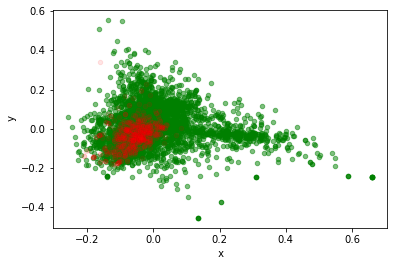

In [41]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn
pca_model = PCA(n_components=3)
tfidf_docs_3d = pca_model.fit_transform(tfidf_docs)
df = pd.DataFrame(tfidf_docs_3d)
ax = df[~mask].plot(x=0, y=1, kind='scatter', alpha=.5, c='green')
df[mask].plot(x=0, y=1, ax=ax, alpha=.1, kind='scatter', c='red')
plt.xlabel(' x')
plt.ylabel(' y')

### 3-dimensional plot

In [42]:
import plotly as py
spam_trace = dict(
        x=df[0][mask], y=df[1][mask], z=df[2][mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='red', line=dict(width=0)) 
    )
ham_trace = dict(
        x=df[0][~mask], y=df[1][~mask], z=df[2][~mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='green', line=dict(width=0)) 
    )
fig = dict(data=[ham_trace, spam_trace], layout={'title': 'LDA Spamminess Model'})
py.offline.plot(fig, filename='lda_spam_3d_scatter.html')

'lda_spam_3d_scatter.html'

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [45]:
sms = pd.read_csv('/Users/yeabinmoon/Documents/ibs_course/BUS243_NLP/nlpia-master/src/nlpia/data/sms-spam.csv',
index_col=0)
lda = LinearDiscriminantAnalysis()

In [46]:
sms

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
4832,1,This is the 2nd time we have tried 2 contact u...
4833,0,Will ü b going to esplanade fr home?
4834,0,"Pity, * was in mood for that. So...any other s..."
4835,0,The guy did some bitching but I acted like i'd...


In [47]:
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs.shape

(4837, 9232)

In [48]:
lda.fit(tfidf_docs, sms.spam)

LinearDiscriminantAnalysis()

In [50]:
sms['predict'] = lda.predict(tfidf_docs)